In [12]:
import numpy as np
import time
import matplotlib.pyplot as plt
from numba import cuda, float32
import pandas as pd

In [10]:
def monte_carlo_cpu(N):
    count = 0
    for _ in range(N):
        x, y = np.random.random(), np.random.random()
        if x*x + y*y <= 1.0:
            count += 1
    return 4.0 * count / N

#Ядро
@cuda.jit
def monte_carlo_gpu_kernel(x, y, results):
    idx = cuda.grid(1)
    if idx < x.size:
        if x[idx]**2 + y[idx]**2 <= 1.0:
            results[idx] = 1
        else:
            results[idx] = 0

def monte_carlo_gpu(N):
    x = np.random.random(N).astype(np.float32)
    y = np.random.random(N).astype(np.float32)

    d_x = cuda.to_device(x)
    d_y = cuda.to_device(y)
    results = cuda.device_array(N, dtype=np.int32)

    threads_per_block = 256
    blocks_per_grid = (N + (threads_per_block - 1)) // threads_per_block

    monte_carlo_gpu_kernel[blocks_per_grid, threads_per_block](d_x, d_y, results)

    inside_circle = results.copy_to_host().sum()
    pi_estimate = 4.0 * inside_circle / N
    return pi_estimate

def run_experiment(N):
    start_cpu = time.time()
    pi_cpu = monte_carlo_cpu(N)
    time_cpu = time.time() - start_cpu

    start_gpu = time.time()
    pi_gpu = monte_carlo_gpu(N)
    time_gpu = time.time() - start_gpu

    return pi_cpu, time_cpu, pi_gpu, time_gpu

Таблица с результатами вычисления числа Pi с использованием CPU и GPU:
   Число точек (N)  Pi (CPU)  Время CPU (сек)  Pi (GPU)  Время GPU (сек)  \
0             1000  3.084000         0.001695  3.104000         0.003755   
1             2000  3.106000         0.002036  3.174000         0.001002   
2             3000  3.141333         0.002967  3.105333         0.000894   
3             4000  3.145000         0.004110  3.188000         0.001204   
4             5000  3.151200         0.004875  3.164800         0.001205   
5             6000  3.154667         0.005916  3.140667         0.001072   
6             7000  3.100000         0.006884  3.144000         0.001069   
7             8000  3.162000         0.008926  3.133500         0.001260   
8             9000  3.152000         0.008945  3.132000         0.001107   
9            10000  3.138400         0.009970  3.124800         0.001173   

   Ускорение  
0   0.451521  
1   2.032604  
2   3.318133  
3   3.412592  
4   4.046102  
5 

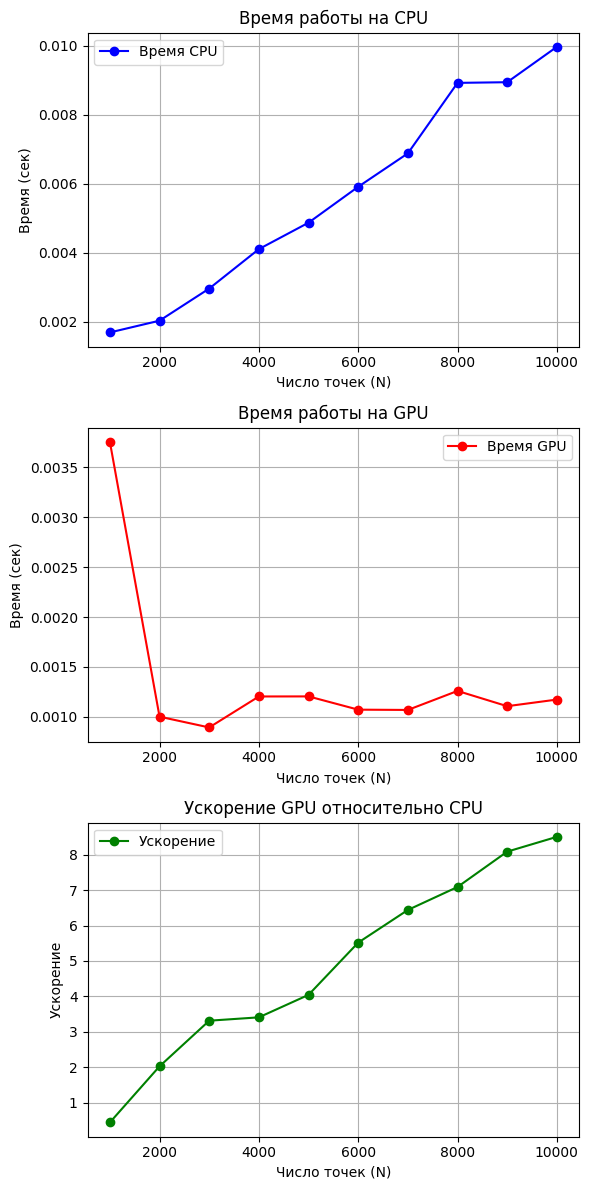

In [26]:
Ns = [10**3, 2*10**3, 3*10**3, 4*10**3, 5*10**3, 6*10**3, 7*10**3, 8*10**3, 9*10**3, 10**4]
cpu_times = []
gpu_times = []
pi_cpu_vals = []
pi_gpu_vals = []

for N in Ns:
    pi_cpu, time_cpu, pi_gpu, time_gpu = run_experiment(N)
    cpu_times.append(time_cpu)
    gpu_times.append(time_gpu)
    pi_cpu_vals.append(pi_cpu)
    pi_gpu_vals.append(pi_gpu)

speedups = [cpu / gpu for cpu, gpu in zip(cpu_times, gpu_times)]

results_df = pd.DataFrame({
    'Число точек (N)': Ns,
    'Pi (CPU)': pi_cpu_vals,
    'Время CPU (сек)': cpu_times,
    'Pi (GPU)': pi_gpu_vals,
    'Время GPU (сек)': gpu_times,
    'Ускорение': speedups
})

print("Таблица с результатами вычисления числа Pi с использованием CPU и GPU:")
print(results_df)

fig, axs = plt.subplots(3, 1, figsize=(6, 12))

#График времени работы CPU
axs[0].plot(Ns, cpu_times, label='Время CPU', marker='o', color='b')
axs[0].set_xlabel('Число точек (N)')
axs[0].set_ylabel('Время (сек)')
axs[0].set_xscale('linear')
axs[0].set_title('Время работы на CPU')
axs[0].grid(True)
axs[0].legend()

#График времени работы GPU
axs[1].plot(Ns, gpu_times, label='Время GPU', marker='o', color='r')
axs[1].set_xlabel('Число точек (N)')
axs[1].set_ylabel('Время (сек)')
axs[1].set_xscale('linear')
axs[1].set_title('Время работы на GPU')
axs[1].grid(True)
axs[1].legend()

#График ускорения
axs[2].plot(Ns, speedups, label='Ускорение', marker='o', color='g')
axs[2].set_xlabel('Число точек (N)')
axs[2].set_ylabel('Ускорение')
axs[2].set_xscale('linear')
axs[2].set_yscale('linear')
axs[2].set_title('Ускорение GPU относительно CPU')
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()